In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
import qiskit.quantum_info as qi
# Tomography functions
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix

from qiskit import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.visualization import *

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

In [2]:
from IPython.core.display import display

n = 5
vectors = []
circuits = []
for i in range(2, n + 1):
    cir = QuantumCircuit(i)
    cir.h(0)
    for j in range(0, i - 1):
        cir.cx(j, j + 1)
    circuits.append(cir)
    vectors.append(qi.Statevector.from_instruction(cir))
drawings = []
for i in range(len(circuits)):
    drawings.append(circuits[i].draw(output='mpl'))

#display(*drawings)

In [3]:
tomo_circuits = []
for cir in circuits:
    tomo_circuits.append(state_tomography_circuits(cir, cir.qubits));

c:\python-interpreters\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
c:\python-interpreters\lib\site-packages\qiskit\circuit\quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
c:\python-interpreters\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
c:\python-interpreters\lib\site-packages\qiski

In [4]:
#lagos simulator
results = []
backend = provider.get_backend('ibm_lagos')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
qcomp = Aer.get_backend("qasm_simulator")
for group in tomo_circuits:
    results.append(qiskit.execute(group, Aer.get_backend('qasm_simulator'), shots=80000).result())


In [ ]:
#Retrive results:
import utility
results = [utility.retrieve("Lagos_fidelity_to_qubits_withMap").result(),
           utility.retrieve("Lagos_fidelity_to_qubits_withMap0").result(),
           utility.retrieve("Lagos_fidelity_to_qubits_withMap1").result(),
           utility.retrieve("Lagos_fidelity_to_qubits_withMap2").result()]


In [5]:
from Tomography import tomography
densities = []
fidelities = {}
purities = {}
for i in range(len(results)):
    tomo_fitter_bell = StateTomographyFitter(results[i], tomo_circuits[i]).fit(method='lstsq')
    densities.append(DensityMatrix(tomo_fitter_bell))
    temp_dict = {i + 2: (tomography.calc_fidelity(DensityMatrix(tomo_fitter_bell), vectors[i]))}
    temp_dict_pure = {i + 2: (tomography.calc_purity(DensityMatrix(tomo_fitter_bell)))}
    fidelities.update(temp_dict)
    purities.update(temp_dict_pure)
print(fidelities)

c:\python-interpreters\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


{2: 0.9984339523441345, 3: 0.9975203291195477, 4: 0.996372694656114, 5: 0.996917367756057}


           2
0.0003646 x - 0.003122 x + 1.003
                         2
(0.000363 + 1.343e-21j) x + (-0.003111 + -9.798e-21j) x + (1.003 + 1.359e-20j)


c:\python-interpreters\lib\site-packages\matplotlib\collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\python-interpreters\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


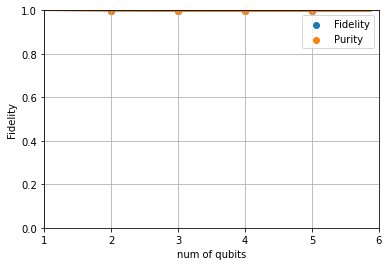

In [6]:
plt.scatter(fidelities.keys(), fidelities.values())
plt.scatter(purities.keys(), purities.values())
plt.axis([1, 6, 0, 1])
plt.ylabel('Fidelity')
plt.xlabel('num of qubits')
plt.legend(["Fidelity", "Purity"])
plt.grid(True)

x = np.linspace(0, 6, 50, False)
poly_f = np.polyfit(list(fidelities.keys()), list(fidelities.values()),2)
poly_p = np.polyfit(list(purities.keys()), list(purities.values()),2)
trendpoly_f = np.poly1d(poly_f)
trendpoly_p = np.poly1d(poly_p)
print(trendpoly_f)
print(trendpoly_p)
plt.plot(x,trendpoly_f(x))
plt.plot(x,trendpoly_p(x))
#plt.plot(fidelities)
plt.show()


In [ ]:
from qiskit.tools import job_monitor
#JAKARTA
import utility
results = []
backend = provider.get_backend('ibm_lagos')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
qcomp = Aer.get_backend("qasm_simulator")
full_layout = [0,1,3,5,4,2,6]
for group in tomo_circuits:
    layout = full_layout[:group[0].num_qubits]
    job = qiskit.execute(group, backend,initial_layout=layout,shots=8000)
    job_monitor(job)
    utility.save_job(job,"Jakarta_fidelity_to_qubits_withMap_(2)")
    results.append(job.result())

In [ ]:
from Tomography import tomography
densities = []
fidelities = {}
purities = {}
for i in range(len(results)):
    tomo_fitter_bell = StateTomographyFitter(results[i], tomo_circuits[i]).fit(method='lstsq')
    densities.append(DensityMatrix(tomo_fitter_bell))
    temp_dict = {i + 2: (tomography.calc_fidelity(DensityMatrix(tomo_fitter_bell), vectors[i]))}
    temp_dict_pure = {i + 2: (tomography.calc_purity(DensityMatrix(tomo_fitter_bell)))}
    fidelities.update(temp_dict)
    purities.update(temp_dict_pure)
print(fidelities)

In [ ]:
plt.scatter(fidelities.keys(), fidelities.values())
plt.scatter(purities.keys(), purities.values())
plt.axis([1, 6, 0, 1])
plt.ylabel('Fidelity')
plt.xlabel('num of qubits')
plt.legend(["Fidelity", "Purity"])
plt.grid(True)

x = np.linspace(0, 6, 50, False)
poly_f = np.polyfit(list(fidelities.keys()), list(fidelities.values()),2)
poly_p = np.polyfit(list(purities.keys()), list(purities.values()),2)
trendpoly_f = np.poly1d(poly_f)
trendpoly_p = np.poly1d(poly_p)
print(trendpoly_f)
print(trendpoly_p)
plt.plot(x,trendpoly_f(x))
plt.plot(x,trendpoly_p(x))
#plt.plot(fidelities)
plt.show()

In [ ]:
from Tomography import utility

results = []
shots = []
backend = provider.get_backend('ibmq_jakarta')

noise_model = NoiseModel.from_backend(backend)
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
qcomp = Aer.get_backend("qasm_simulator")

circuit = tomo_circuits[3]
full_layout = [0,1,3,5,4]
i = 0
n_shots = 1
while n_shots < 8000:
    store = False
    if n_shots == 2048:
        store = True

    print(n_shots)
    #results.append(utility.execute(circuit, 'ibm_lagos', str(n_shots) + " shots 5 qubit cat state" , shots=n_shots).result())
    results.append(qiskit.execute(circuit, Aer.get_backend('qasm_simulator'),
                                  coupling_map=coupling_map,
                                  basis_gates=basis_gates,
                                  noise_model=noise_model,initial_layout=full_layout, shots=n_shots).result())
    shots.append(i)
    i += 1
    n_shots = pow(2, i)



In [ ]:
from Tomography import utility
#lagos not simulator
results = []
shots = []
backend = provider.get_backend('ibmq_jakarta')



circuit = tomo_circuits[3]
full_layout = [0,1,3,5,4]
i = 0
n_shots = 1
while n_shots < 8000:
    store = False
    if n_shots == 2048:
        store = True

    print(n_shots)
    #results.append(utility.execute(circuit, 'ibm_lagos', str(n_shots) + " shots 5 qubit cat state" , shots=n_shots).result())
    job = qiskit.execute(circuit, backend,initial_layout=full_layout,shots=n_shots)
    job_monitor(job)
    utility.save_job(job,"Jakarta_fidelity_to_shots_withMap_(1)")
    results.append(job.result())

    shots.append(i)
    i += 1
    n_shots = pow(2, i)


In [ ]:
print(results)
fidelities = {}
purities = {}
for i in range(len(results)):
    tomo_fitter_bell = StateTomographyFitter(results[i], tomo_circuits[3]).fit(method='lstsq')
    densities.append(DensityMatrix(tomo_fitter_bell))
    temp_dict = {shots[i]: (pow(qi.state_fidelity(DensityMatrix(tomo_fitter_bell), vectors[3]), 2))}
    fidelities.update(temp_dict)
    temp_dict_pure = {shots[i]: (np.absolute(qi.purity(tomo_fitter_bell)))}
    purities.update(temp_dict_pure)

In [ ]:
from matplotlib.axes import Axes

plt.scatter(fidelities.keys(), fidelities.values())
plt.scatter(purities.keys(), purities.values(), color="orange")
plt.legend(["Fidelity", "Purity"])
plt.axis([0, 15, 0, 1])
plt.title('5 qubit cat state')
plt.ylabel('Fidelity')
plt.xlabel('num of shots - 2^n')

plt.grid(True)

x = np.linspace(0, 12, 50, False)
poly_f = np.polyfit(list(fidelities.keys()), list(fidelities.values()),2)
poly_p = np.polyfit(list(purities.keys()), list(purities.values()),2)
trendpoly_f = np.poly1d(poly_f)
trendpoly_p = np.poly1d(poly_p)
print(trendpoly_f)
print(trendpoly_p)
plt.plot(x,trendpoly_f(x))
plt.plot(x,trendpoly_p(x))
#plt.plot(fidelities)
plt.show()

In [ ]:
print("Average purity: ", np.mean(list(purities.values())))
print("Purity standard deviation: ", np.std(list(purities.values())))
print("Average fidelity: ", np.mean(list(fidelities.values())))
print("Fidelity standard deviation: ", np.std(list(fidelities.values())))

In [ ]:
import random

i = 0
diluted = []
n_shots = 1
print(results[len(results) - 1].get_memory(2))

#keys = random.sample(results[len(results)-1].keys(), 10)


#while n_shots < 8000:
#    for x,y in results[len(results)-1]:
#
#    diluted.append(i)
#    i += 1
#    n_shots = pow(2,i)

